# Tspiral

A python package for time series forecasting with scikit-learn estimators.

tspiral is not a library that works as a wrapper for other tools and methods for time series forecasting. tspiral directly provides scikit-learn estimators for time series forecasting. It leverages the benefit of using scikit-learn syntax and components to easily access the open source ecosystem built on top of the scikit-learn community. It easily maps a complex time series forecasting problems into a tabular supervised regression task, solving it with a standard approach.

## Overview

tspiral provides 4 optimized forecasting techniques:

### Recursive Forecasting

Lagged target features are combined with exogenous regressors (if provided) and lagged exogenous features (if specified). A scikit-learn compatible regressor is fitted on the whole merged data. The fitted estimator is called iteratively to predict multiple steps ahead.

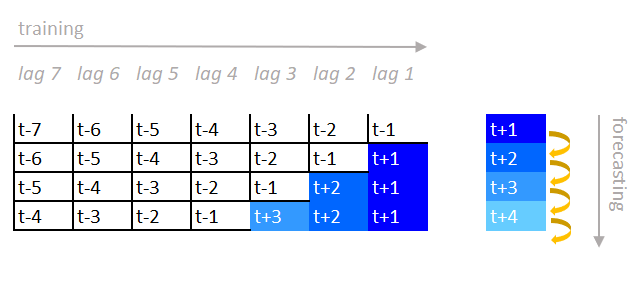

### Direct Forecasting

A scikit-learn compatible regressor is fitted on the lagged data for each time step to forecast.

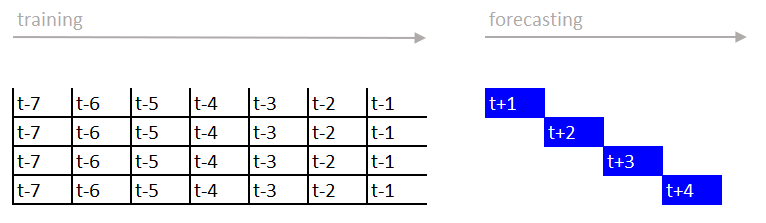

### Stacking Forecasting 

Multiple recursive time series forecasters are fitted and combined on the final portion of the training data with a meta-learner.

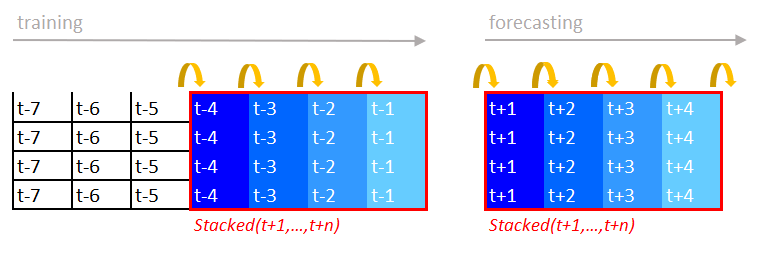

### Rectified Forecasting

Multiple recursive time series forecasters are fitted on different sliding window training bunches. Forecasts are adjusted and combined fitting a meta-learner for each forecasting step.

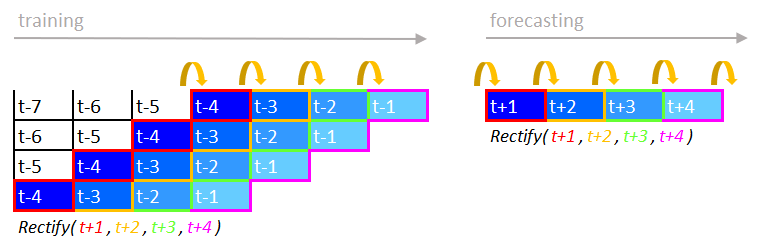

Multivariate time series forecasting is natively supported for all the forecasting methods available.

## Installation

In [1]:
!pip install --upgrade tspiral

In [33]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from tsprial.forecasting import *

### Загрузка датасета

In [34]:
data = pd.read_csv("1018566_19.csv")
data.head(5)

,Unnamed: 0,time,ta_id,blockID,blockDur,t_trp,b_trp,real_time
0,83565,2018/01/01 05,19.0,63584433.0,180.0,0.991,1.283,2018-01-01 05:10:00
1,83566,2018/01/01 05,19.0,60701205.0,180.0,0.817,0.793,2018-01-01 05:35:00
2,83567,2018/01/01 05,19.0,60701203.0,180.0,1.098,1.493,2018-01-01 05:50:00
3,83568,2018/01/01 06,19.0,60701161.0,195.0,0.468,0.584,2018-01-01 06:35:00
4,83569,2018/01/01 06,19.0,60701162.0,210.0,0.382,0.457,2018-01-01 06:50:00


### Необходимо предсказать значения столбца t_trp, сгруппируем его с временным столбцом

In [4]:
df_new = data.groupby('time')['t_trp'].agg('mean').reset_index()
df_new

,time,t_trp
0,2018/01/01 05,0.968667
1,2018/01/01 06,0.425000
2,2018/01/01 07,0.655000
3,2018/01/01 08,0.909500
4,2018/01/01 09,1.420500
...,...,...
32858,2022/06/05 21,1.746667
32859,2022/06/05 22,1.530000
32860,2022/06/05 23,1.334500
32861,2022/06/06 00,0.344500


### Визуализация последних 2863 значений ряда

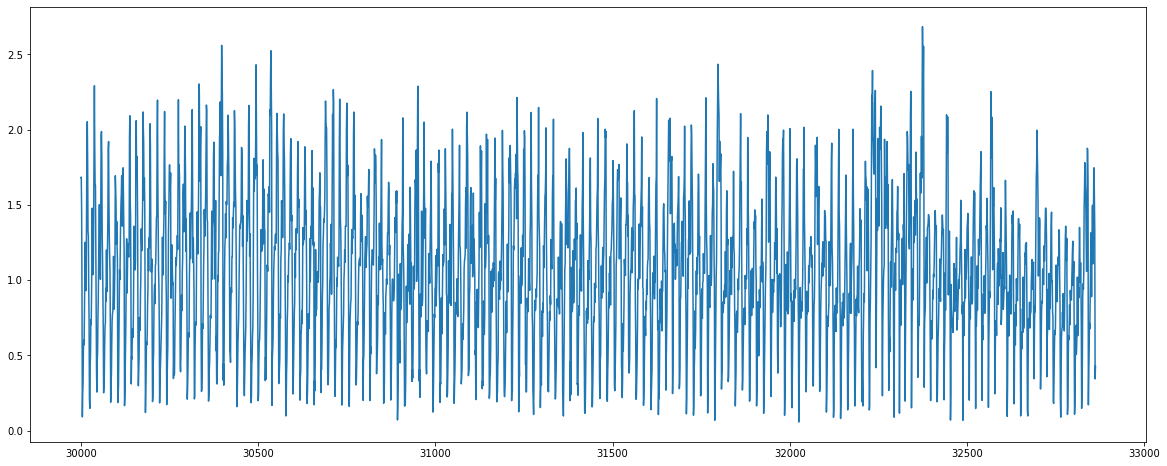

In [5]:
plt.figure(figsize=(20,8))
plt.plot(df_new['t_trp'][30000:])

### Тест на стационарность

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
test_stationarity(df_new["t_trp"])

Results of Dickey-Fuller Test:
Test Statistic                -1.530669e+01
p-value                        4.240513e-28
#Lags Used                     4.700000e+01
Number of Observations Used    3.281500e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64


###  Индекс по которому будем разбивать на тестовую и тренировочную выборки

In [8]:
test_index = int(len(df_new)*(1-0.2))

In [9]:
y = df_new["t_trp"]
y

0        0.968667
1        0.425000
2        0.655000
3        0.909500
4        1.420500
           ...   
32858    1.746667
32859    1.530000
32860    1.334500
32861    0.344500
32862    0.429500
Name: t_trp, Length: 32863, dtype: float64

### Разбиваем y на тренировочную и тестовую выборку

In [10]:
y_train = df_new.loc[:test_index]["t_trp"]
y_test = df_new.loc[test_index:]["t_trp"]

In [11]:
y_train.shape, y_test.shape

((26291,), (6573,))

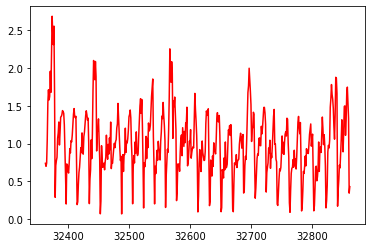

In [12]:
plt.plot(y_test.tail(500).index, df_new["t_trp"].tail(500).values, c='red')

### Recursive forecasting

#### Подбираем гиперпараметры

In [49]:
best_score = np.inf
best_order = None
for i in range(1,24):
    try:
        model = ForecastingCascade(
        Ridge(),
        lags=range(1,24*i+1),  
        use_exog=False,
        accept_nan=False
     )
        model.fit(np.arange(len(y_train)), y_train)
        score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
        tmp_score = score
        if tmp_score < best_score:
            best_score = tmp_score
            best_order = i
    except: continue
print('mse: ', best_score, " lag: ", best_order)

mse:  0.24838223676090157  lag:  12


In [13]:
CV = TimeSeriesSplit(5, test_size=24*7)

model = GridSearchCV(
    ForecastingCascade(
        Ridge(),
        lags=range(1,24*12+1), 
        use_exog=False,
        accept_nan=False
    ), 
    param_grid={'estimator__alpha': [1,2,3,5,10]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)

model.fit(np.arange(len(y_train)), y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=288),
             estimator=ForecastingCascade(estimator=Ridge(),
                                          lags=range(1, 289)),
             n_jobs=-1, param_grid={'estimator__alpha': [1, 2, 3, 5, 10]},
             scoring='neg_mean_squared_error')

In [51]:
model.best_params_, model.best_estimator_.score(np.arange(len(y_test)), y_test, scoring='mse')

({'estimator__alpha': 10}, 0.24837863067087207)

### Обучаем модель с учетом найденных гиперпараметров

In [52]:
model = ForecastingCascade(
    Ridge(alpha=10.0),
    lags=range(1,24*12+1),  
    use_exog=False,
    accept_nan=False
)
model.fit(np.arange(len(y_train)), y_train)

ForecastingCascade(estimator=Ridge(alpha=10.0), lags=range(1, 289))

In [54]:
score1 = model.score(np.arange(len(y_test)), y_test, scoring='rmse')
score1

0.4983759932730228

#### Предсказанные и действитительные значения (~ за месяц)

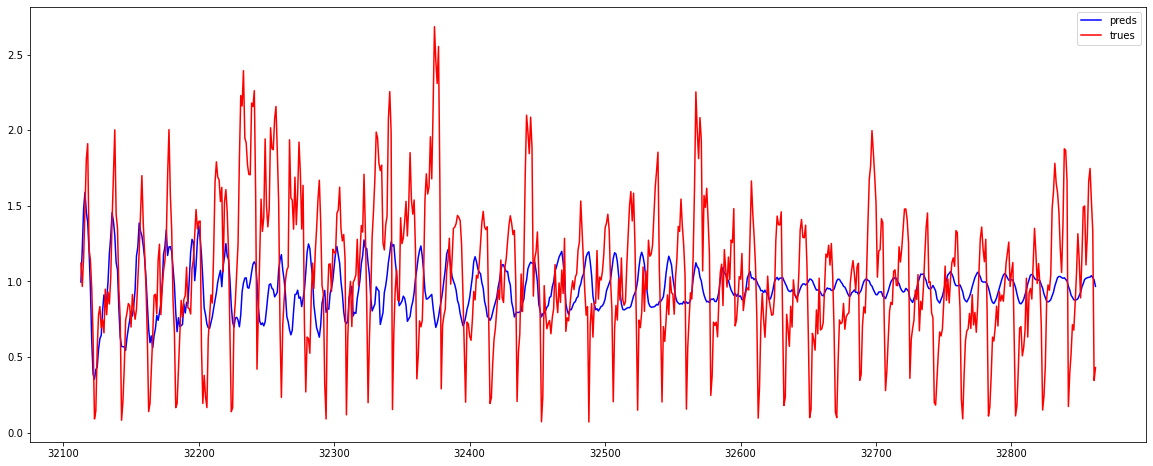

In [56]:
plt.figure(figsize=(20,8))
plt.plot(y_test.tail(750).index, model.predict(np.arange(len(y_test.tail(750)))), c='blue', label='preds')
plt.plot(y_test.tail(750).index, y_test.tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

###  Прогноз (~ месяц)

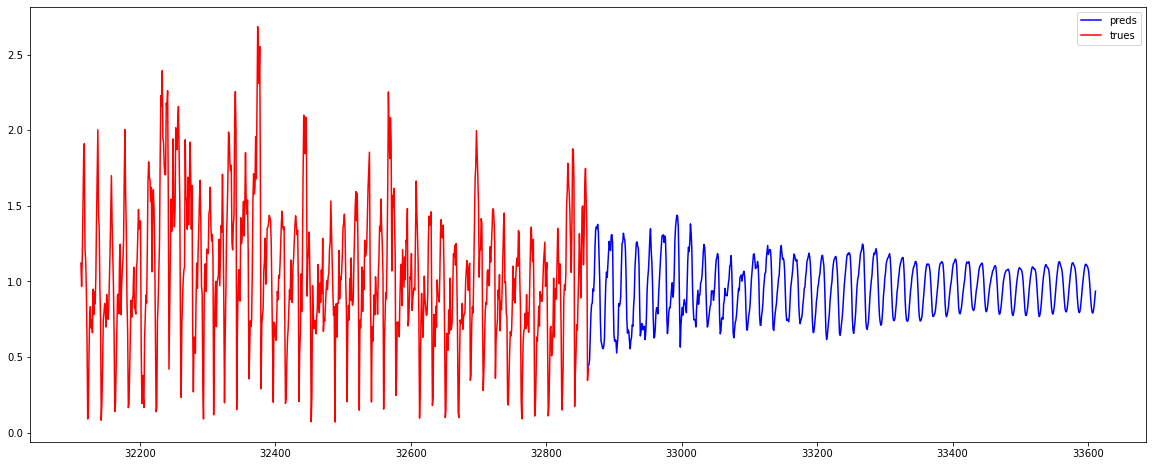

In [58]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(750) + df_new["t_trp"].index[-1], model.predict(np.arange(750), last_y=df_new["t_trp"].tail(750)), c='blue', label='preds')
plt.plot(y_test.tail(750).index, df_new["t_trp"].tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

### Direct forecasting

#### Подбираем гиперпараметры

In [59]:
best_score = np.inf
best_order = None
for i in range(1, 50):
    try:
        model = ForecastingChain(
        Ridge(),
        n_estimators=24*3,
        lags=range(1,24*i+1),  
        use_exog=False,
        accept_nan=False
    )
        model.fit(np.arange(len(y_train)), y_train)
        score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
        tmp_score = score
           
        if tmp_score < best_score:
            best_score = tmp_score
            best_order = i
    except: continue
print('mse: ', best_score, " lag: ", best_order)

mse:  0.2497748358369599  lag:  10


In [60]:
CV = TimeSeriesSplit(5, test_size=24*7)

model = GridSearchCV(
    ForecastingChain(
        Ridge(),
        n_estimators=24*3,
        lags=range(1,24*10+1), 
        use_exog=False,
        accept_nan=False
    ), 
    param_grid={'estimator__alpha': [1,2,3,5,10]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)

model.fit(np.arange(len(y_train)), y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=168),
             estimator=ForecastingChain(estimator=Ridge(), lags=range(1, 241),
                                        n_estimators=72),
             n_jobs=-1, param_grid={'estimator__alpha': [1, 2, 3, 5, 10]},
             scoring='neg_mean_squared_error')

In [61]:
model.best_params_, model.best_estimator_.score(np.arange(len(y_test)), y_test, scoring='mse')

({'estimator__alpha': 1}, 0.2497748358369599)

####  Обучаем модель с учетом найденных гиперпараметров

In [62]:
model = ForecastingChain(
        Ridge(alpha=1.0),
        n_estimators=24*3,
        lags=range(1,24*10+1),  
        use_exog=False,
        accept_nan=False
)

In [63]:
model.fit(np.arange(len(y_train)), y_train)
score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
score1 = model.score(np.arange(len(y_test)), y_test, scoring='rmse')
print("mse: {}, rmse: {}".format(score,score1))

mse: 0.2497748358369599, rmse: 0.49977478511521556


### Предсказанные и действитительные значения (~ за месяц) 

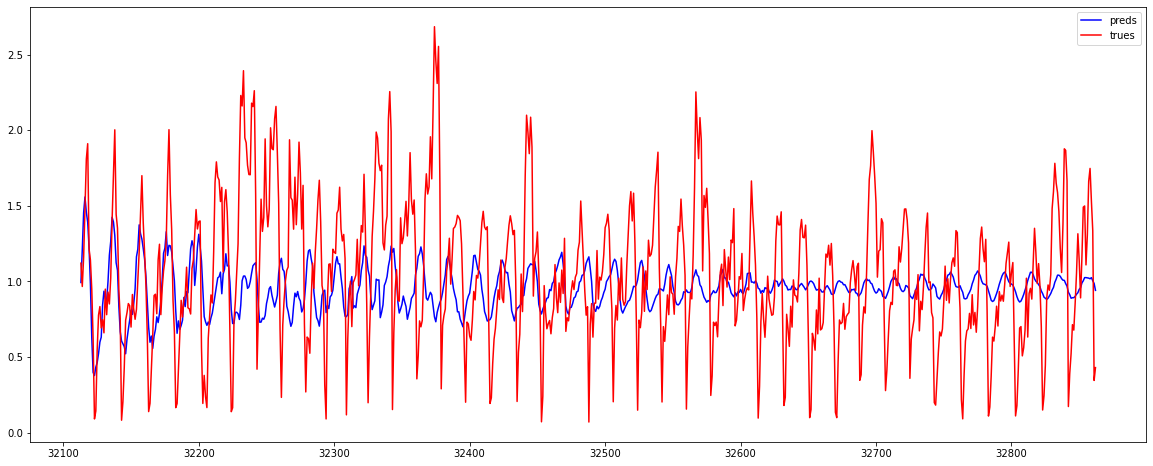

In [64]:
plt.figure(figsize=(20,8))
plt.plot(y_test.tail(750).index, model.predict(np.arange(len(y_test.tail(750)))), c='blue', label='preds')
plt.plot(y_test.tail(750).index, y_test.tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

####  Прогноз (~  на месяц)

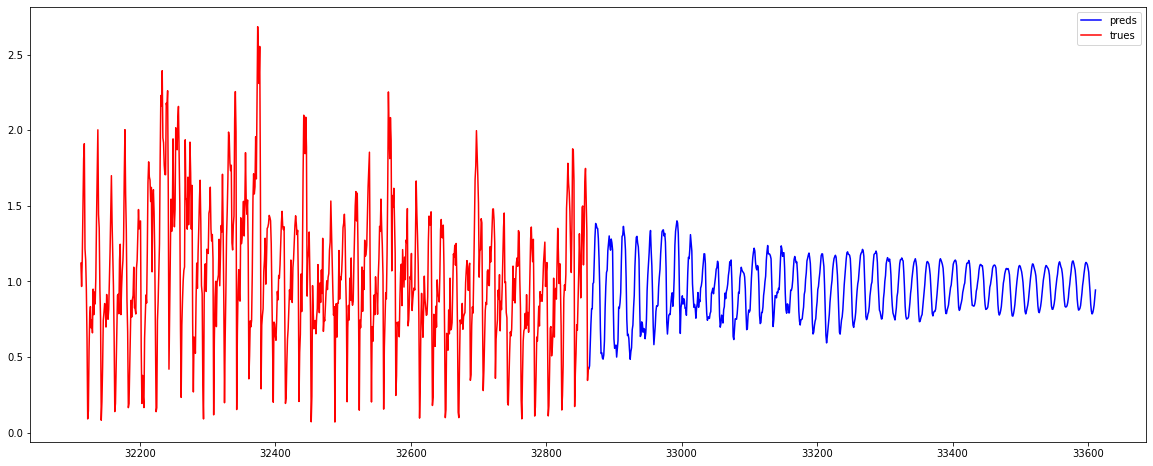

In [65]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(750) + df_new["t_trp"].index[-1], model.predict(np.arange(750), last_y=df_new["t_trp"].tail(750)), c='blue', label='preds')
plt.plot(y_test.tail(750).index, df_new["t_trp"].tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

### Stacked forecasting

#### Подбор гиперпараметров 

In [66]:
best_score = np.inf
best_order = None
for i in range(1, 24):
    try:
        model = ForecastingStacked(
        [DecisionTreeRegressor(), Ridge()],
        test_size=len(y_test),
        lags=range(1,24*i+1),  
        use_exog=False
     )
        model.fit(np.arange(len(y_train)), y_train)
        score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
        tmp_score = score
        if tmp_score < best_score:
            best_score = tmp_score
            best_order = i
    except: continue
print('mse: ', best_score, " lag: ", best_order)

mse:  0.24146611848439217  lag:  12


In [67]:
CV = TimeSeriesSplit(5, test_size=24*7)

model1 = GridSearchCV(
    ForecastingCascade(
        DecisionTreeRegressor(),
        lags=range(1,24*12+1), 
        use_exog=False
    ), 
    param_grid={'estimator__max_depth': [10,20,None]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model1.fit(np.arange(len(y_train)), y_train)

model2 = GridSearchCV(
    ForecastingCascade(
        Ridge(),
        lags=range(1,24*12+1),
        use_exog=False
    ), 
    param_grid={'estimator__alpha': [1,2,3,5,10]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
model2.fit(np.arange(len(y_train)), y_train)

model = ForecastingStacked(
    [DecisionTreeRegressor(**{p.replace('estimator__',''): v for p,v in model1.best_params_.items()}), 
     Ridge(**{p.replace('estimator__',''): v for p,v in model2.best_params_.items()})],
    test_size=len(y_test),
    lags=range(1,24*12+1), 
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train)

ForecastingStacked(estimators=[DecisionTreeRegressor(max_depth=10),
                               Ridge(alpha=10)],
                   lags=range(1, 289), test_size=6573)

In [68]:
model.score(np.arange(len(y_test)), y_test, scoring='mse')

0.24228574842235281

#### Обучаем модель с учетом найденных гиперпараметров 

In [74]:
model = ForecastingStacked(
    [DecisionTreeRegressor(max_depth=10), Ridge(alpha=10)],
    test_size=len(y_test),
    lags=range(1,24*12+1),  
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train)

ForecastingStacked(estimators=[DecisionTreeRegressor(max_depth=10),
                               Ridge(alpha=10)],
                   lags=range(1, 289), test_size=6573)

In [75]:
score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
score1 = model.score(np.arange(len(y_test)), y_test, scoring='rmse')
print("mse: {}, rmse: {}".format(score,score1))

mse: 0.2440535320119189, rmse: 0.4940177446326386


#### Предсказанные и действитительные значения (~ за месяц) 

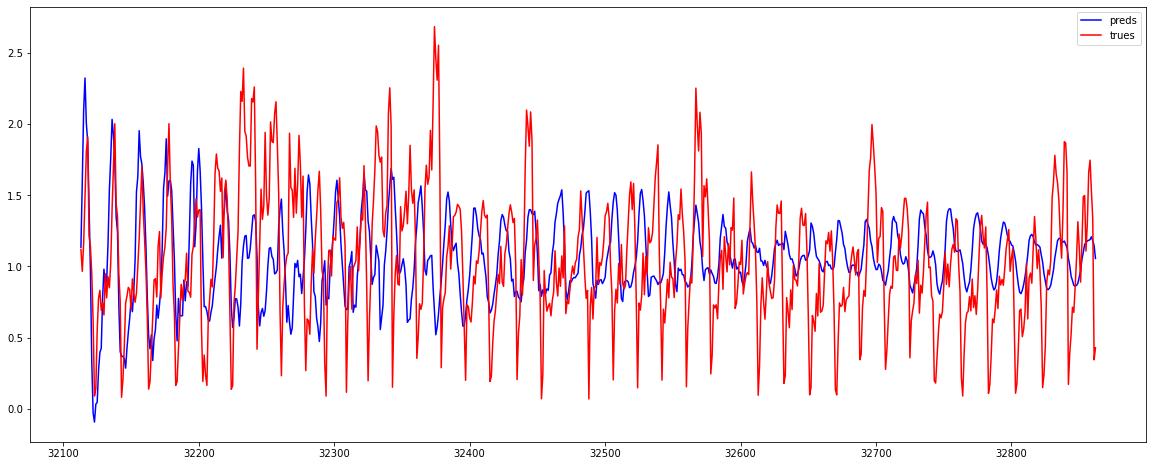

In [76]:
plt.figure(figsize=(20,8))
plt.plot(y_test.tail(750).index, model.predict(np.arange(len(y_test.tail(750)))), c='blue', label='preds')
plt.plot(y_test.tail(750).index, y_test.tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

#### Прогноз (~ на месяц) 

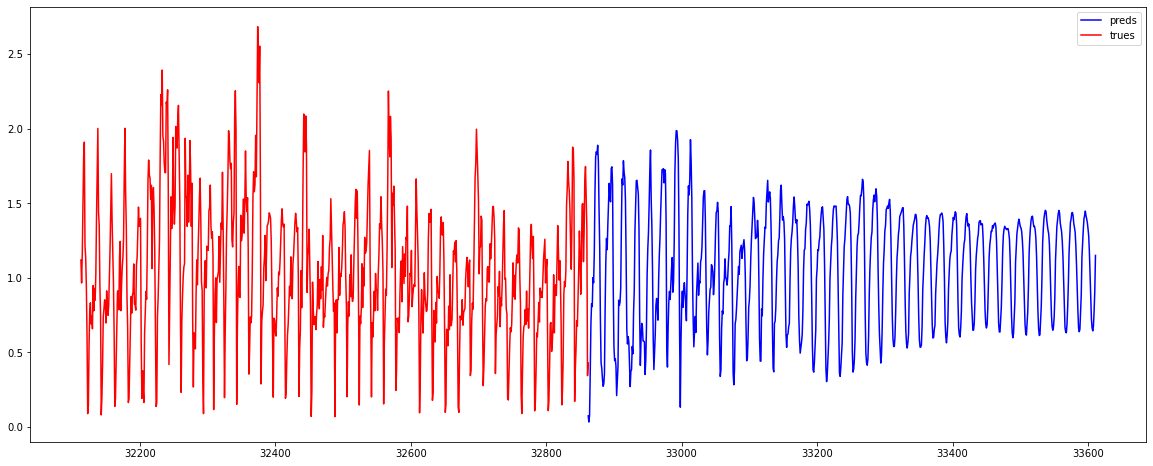

In [77]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(750) + df_new["t_trp"].index[-1], model.predict(np.arange(750), last_y=df_new["t_trp"].tail(750)), c='blue', label='preds')
plt.plot(y_test.tail(750).index, df_new["t_trp"].tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

### Rectified forecasting

#### Подбор гиперпараметров 

In [92]:
best_score = np.inf
best_order = None
for i in range(12,50):
    try:
        model = ForecastingRectified(
        Ridge(),
        test_size=24*7,
        n_estimators=100,
        lags=range(1,24*i+1),  
        use_exog=False
     )
        model.fit(np.arange(len(y_train)), y_train)
        score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
        tmp_score = score
        if tmp_score < best_score:
            best_score = tmp_score
            best_order = i
    except: continue
print('mse: ', best_score, " lag: ", best_order)

mse:  0.24227140848912299  lag:  12


In [41]:
CV = TimeSeriesSplit(5, test_size=24*7)

model = GridSearchCV(
    ForecastingRectified(
        Ridge(),
        test_size=24*8,
        n_estimators=100,
        lags=range(1,24*12+1),  
        use_exog=False
    ), 
    param_grid={'estimator__alpha': [160, 170, 180, 200]},
    cv=CV, n_jobs=-1,
    scoring='neg_mean_squared_error'
)

model.fit(np.arange(len(y_train)), y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=168),
             estimator=ForecastingRectified(estimator=Ridge(),
                                            lags=range(1, 289),
                                            n_estimators=100, test_size=192),
             n_jobs=-1, param_grid={'estimator__alpha': [160, 170, 180, 200]},
             scoring='neg_mean_squared_error')

In [42]:
model.best_params_, model.best_estimator_.score(np.arange(len(y_test)), y_test, scoring='mse')

({'estimator__alpha': 200}, 0.24185600227094164)

#### Обучаем модель с учетом найденных гиперпараметров

In [43]:
model = ForecastingRectified(
    Ridge(alpha=200),
    test_size=24*8,
    n_estimators=100,
    lags=range(1,24*12+1),  
    use_exog=False
)
model.fit(np.arange(len(y_train)), y_train)

ForecastingRectified(estimator=Ridge(alpha=200), lags=range(1, 289),
                     n_estimators=100, test_size=192)

In [44]:
score = model.score(np.arange(len(y_test)), y_test, scoring='mse')
score1 = model.score(np.arange(len(y_test)), y_test, scoring='rmse')
print("mse: {}, rmse: {}".format(score,score1))

mse: 0.24185600227094164, rmse: 0.49178857476657756


#### Предсказанные и действитительные значения (~ за месяц) 

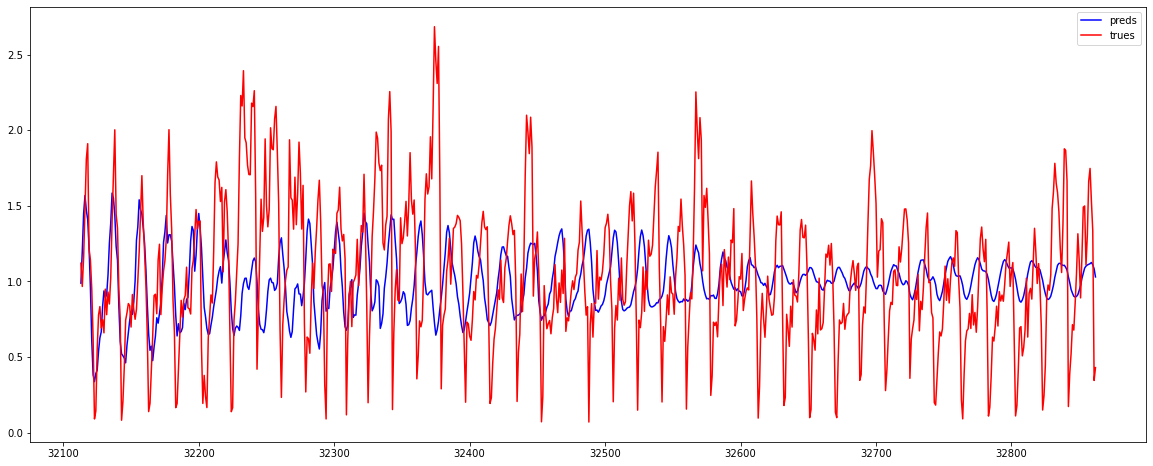

In [45]:
plt.figure(figsize=(20,8))
plt.plot(y_test.tail(750).index, model.predict(np.arange(len(y_test.tail(750)))), c='blue', label='preds')
plt.plot(y_test.tail(750).index, y_test.tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

#### Прогноз (~ на месяц)

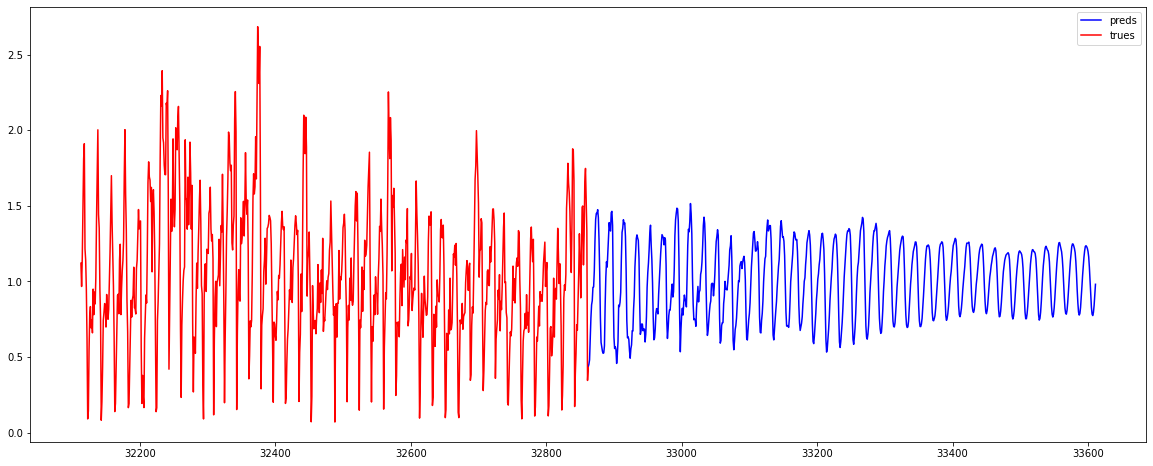

In [46]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(750) + df_new["t_trp"].index[-1], model.predict(np.arange(750), last_y=df_new["t_trp"].tail(750)), c='blue', label='preds')
plt.plot(y_test.tail(750).index, df_new["t_trp"].tail(750).values, c='red', label='trues')
plt.legend(); plt.show()

Лучший результат получен при применении Stacked forecasting